## Testing Surrogated-Sources Approach

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import tensorflow  as tf
from tensorflow.keras              import backend as K
from tensorflow.keras              import activations, initializers
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import Layer, Dense, Activation, Dropout
from tensorflow.keras              import Input
from tensorflow.keras.regularizers import l2

from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler

from scipy.integrate import solve_ivp

3.8.10 (default, May  4 2021, 03:05:50) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [2]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data_10_0DReact/'
TestDir    = WORKSPACE_PATH+'/ROMNet/Data_10_0DReact_Test/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass
try:
    os.makedirs(TestDir)
except OSError as e:
    pass

NVarsRed           = 3

NPerT0             = 100
tStratch           = 1.
NtTrain            = NPerT0*2
SOLVER             = 'BDF'



In [3]:
### Retrieving Data

Vars = []
for iVars in range(1,NVarsRed+1):
    Vars.append('PC_'+str(iVars))

SVars = []
for iVars in range(1,NVarsRed+1):
    SVars.append('SPC_'+str(iVars))
    
FileName     = OutputDir + '/orig_data/yCleaned.csv'
yMatOrig     = pd.read_csv(FileName, header=0)
VarNames     = list(yMatOrig.columns)
yMat         = yMatOrig.to_numpy()

FileName     = OutputDir + '/orig_data/T0VecTot.csv'
Data         = pd.read_csv(FileName, header=None)
T0VecTot     = np.log10(Data.to_numpy())
    
FileName     = OutputDir+'/orig_data/t.csv'
Data         = pd.read_csv(FileName, header=None)
tVec         = Data.to_numpy()[:,0]

FileName     = OutputDir+'/pc_data_'+str(NVarsRed)+'/PC.csv'
Data         = pd.read_csv(FileName, header=0)
yMat_pca     = Data[Vars].to_numpy()

FileName     = OutputDir+'/pc_data_'+str(NVarsRed)+'/PCSource.csv'
DataS        = pd.read_csv(FileName, header=0)
ySource_pca  = DataS[SVars].to_numpy()

In [4]:
# fig  = plt.figure(figsize=(16,12))
# plt.plot(tVec, yMat_pca[:,2], '-k',  linewidth=2)
# plt.xscale('log')

Text(0.5, 0, '$dPC_3/dt$')

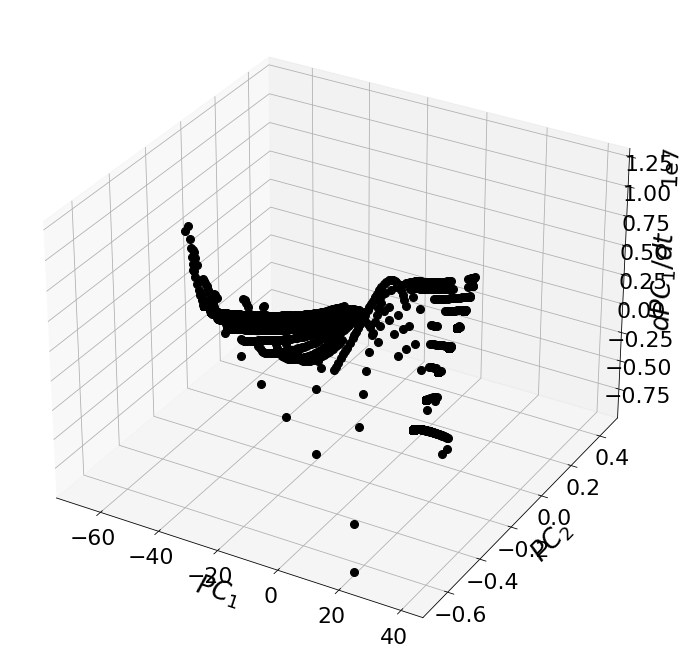

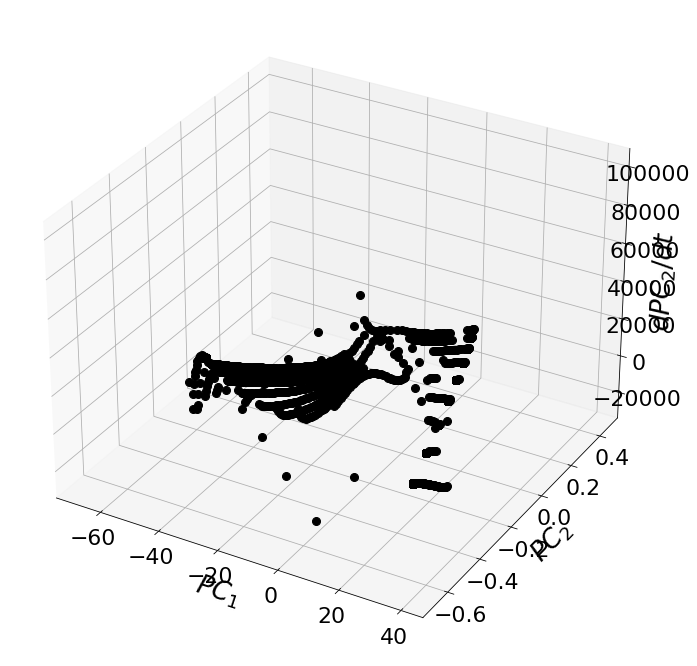

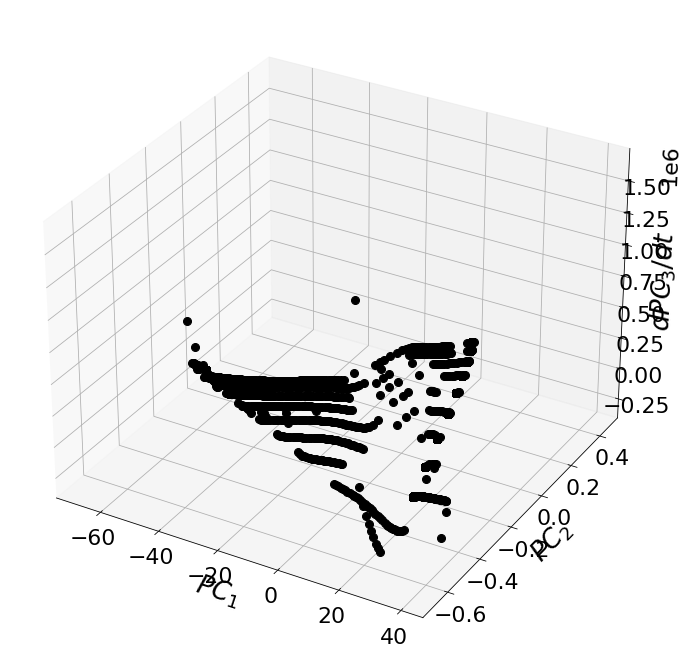

In [5]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], yMat_pca[:,1], ySource_pca[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_1/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], yMat_pca[:,1], ySource_pca[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_2/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], yMat_pca[:,1], ySource_pca[:,2], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_3/dt$')

In [6]:
### Normalizing Data

xMax      = yMat_pca.max(0)
xMin      = yMat_pca.min(0)
xRange    = (xMax-xMin)
if (xRange[-1] == 0):
    xRange[-1] = 1.0
yMatt_pca = (yMat_pca-xMin)/xRange

yMax         = ySource_pca.max(0)
yMin         = ySource_pca.min(0)
yRange       = (yMax-yMin)
ySourcee_pca = (ySource_pca-yMin)/yRange

Nx = yMatt_pca.shape[1]
Nd = yMatt_pca.shape[0]
Ny = ySourcee_pca.shape[1]

Text(0.5, 0, '$dPC_3/dt$')

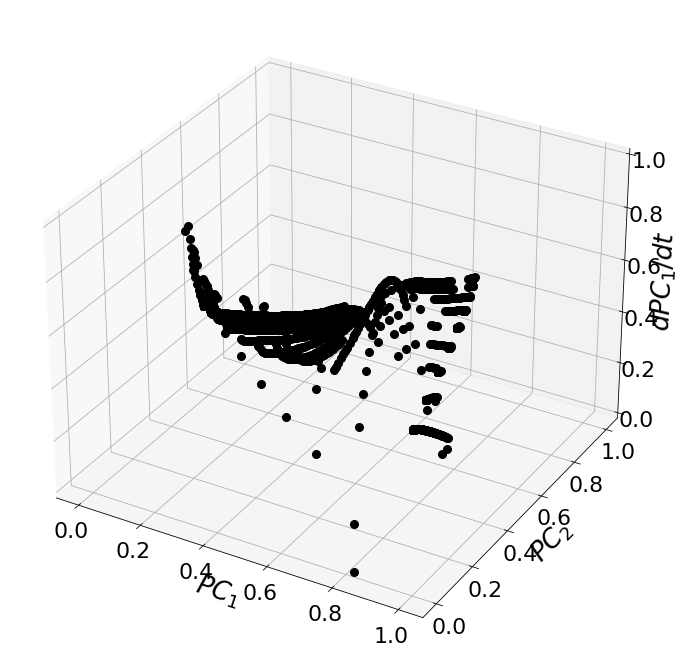

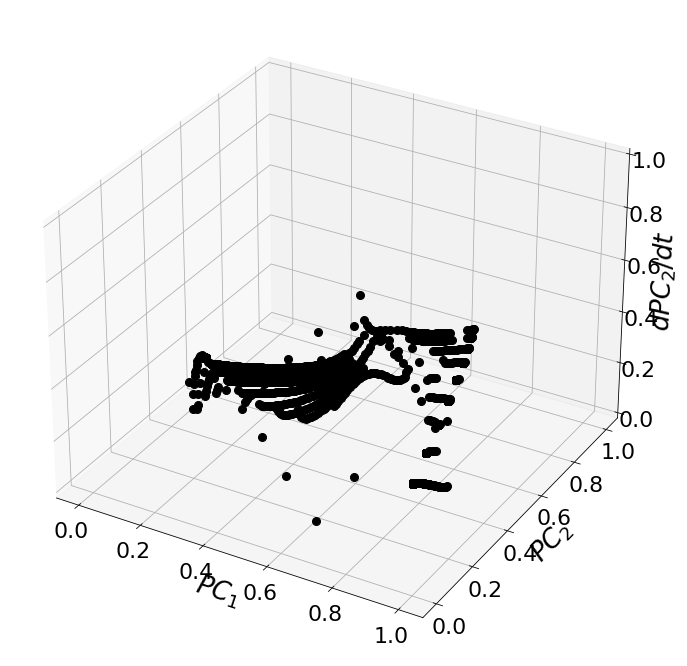

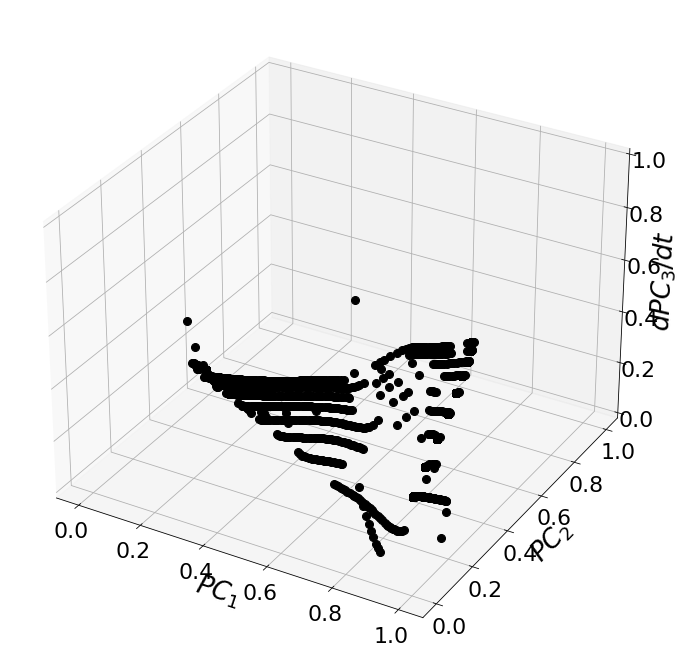

In [7]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_1/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_2/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca[:,2], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_3/dt$')

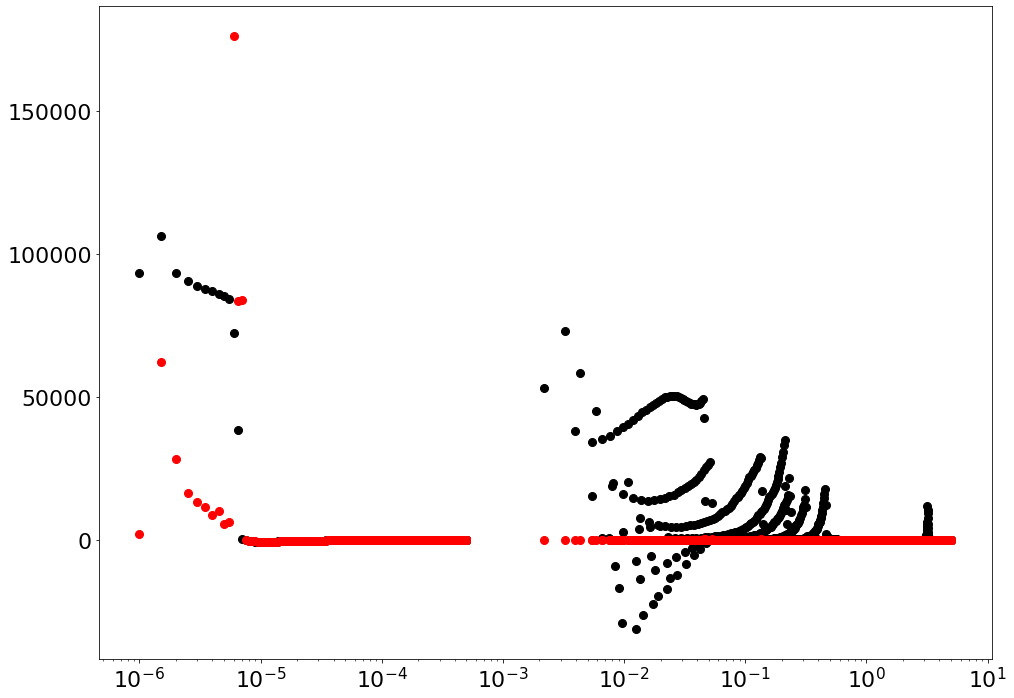

In [8]:
### Checking Data

from numpy import diff

iPC = 1

dydt = diff(yMat_pca[:,iPC])/diff(tVec)

fig = plt.figure(figsize=(16,12))
plt.plot(tVec, ySource_pca[:,iPC], 'ko')
plt.plot(tVec[1:], dydt, 'ro')
plt.xscale('log')

In [9]:
### Splitting Data

XTrain, XTest, yTrain, yTest = train_test_split(yMatt_pca, ySourcee_pca, test_size=0.2, random_state=3)

In [10]:
### Creating Surrogate

NNModel = tf.keras.models.Sequential()

NNModel.add(Dense(NNeurons[0], input_shape=(Nx,), activation=Activations[0], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
for iHL in range(1, len(NNeurons)):
    NNModel.add(Dense(NNeurons[iHL], activation=Activations[iHL], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
NNModel.add(Dense(Ny, activation='linear'))
NNModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 20,995
Trainable params: 20,995
Non-trainable params: 0
____________________________________________________

In [11]:
### Training Surrogate

Optimizer = OptimizerName(learning_rate=LearningRate)
NNModel.compile(optimizer=Optimizer, loss='mse')
Training  = NNModel.fit(XTrain, yTrain, batch_size=NBatch, epochs=NEpoch, validation_data=(XTest, yTest), verbose=1);

Epoch 1/2500
63/63 [==============================] - 1s 3ms/step - loss: 0.0747 - val_loss: 0.0459
Epoch 2/2500
63/63 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0261
Epoch 3/2500
63/63 [==============================] - 0s 1ms/step - loss: 0.0250 - val_loss: 0.0239
Epoch 4/2500
63/63 [==============================] - 0s 1ms/step - loss: 0.0231 - val_loss: 0.0223
Epoch 5/2500
63/63 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0210
Epoch 6/2500
63/63 [==============================] - 0s 2ms/step - loss: 0.0205 - val_loss: 0.0199
Epoch 7/2500
63/63 [==============================] - 0s 1ms/step - loss: 0.0195 - val_loss: 0.0189
Epoch 8/2500
63/63 [==============================] - 0s 1ms/step - loss: 0.0185 - val_loss: 0.0180
Epoch 9/2500
63/63 [==============================] - 0s 1ms/step - loss: 0.0176 - val_loss: 0.0171
Epoch 10/2500
63/63 [==============================] - 0s 1ms/step - loss: 0.0168 - val_loss: 0.0163

63/63 [==============================] - 0s 2ms/step - loss: 8.1564e-04 - val_loss: 7.6641e-04
Epoch 160/2500
63/63 [==============================] - 0s 2ms/step - loss: 8.1546e-04 - val_loss: 7.6645e-04
Epoch 161/2500
63/63 [==============================] - 0s 1ms/step - loss: 8.1213e-04 - val_loss: 7.6384e-04
Epoch 162/2500
63/63 [==============================] - 0s 1ms/step - loss: 8.1167e-04 - val_loss: 7.6034e-04
Epoch 163/2500
63/63 [==============================] - 0s 1ms/step - loss: 8.0883e-04 - val_loss: 7.5505e-04
Epoch 164/2500
63/63 [==============================] - 0s 2ms/step - loss: 8.0628e-04 - val_loss: 7.5509e-04
Epoch 165/2500
63/63 [==============================] - 0s 2ms/step - loss: 8.0527e-04 - val_loss: 7.5537e-04
Epoch 166/2500
63/63 [==============================] - 0s 2ms/step - loss: 8.0508e-04 - val_loss: 7.6253e-04
Epoch 167/2500
63/63 [==============================] - 0s 1ms/step - loss: 8.0074e-04 - val_loss: 7.4814e-04
Epoch 168/2500
63/63 [===

63/63 [==============================] - 0s 2ms/step - loss: 7.0113e-04 - val_loss: 6.4480e-04
Epoch 308/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.9761e-04 - val_loss: 6.4802e-04
Epoch 309/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.9752e-04 - val_loss: 6.4292e-04
Epoch 310/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.9697e-04 - val_loss: 6.4524e-04
Epoch 311/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.9709e-04 - val_loss: 6.4057e-04
Epoch 312/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.9546e-04 - val_loss: 6.4103e-04
Epoch 313/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.9565e-04 - val_loss: 6.5696e-04
Epoch 314/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.9771e-04 - val_loss: 6.4413e-04
Epoch 315/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.9592e-04 - val_loss: 6.4210e-04
Epoch 316/2500
63/63 [===

63/63 [==============================] - 0s 1ms/step - loss: 6.6127e-04 - val_loss: 6.0735e-04
Epoch 456/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.5954e-04 - val_loss: 6.0270e-04
Epoch 457/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.5871e-04 - val_loss: 6.0238e-04
Epoch 458/2500
63/63 [==============================] - 0s 2ms/step - loss: 6.5944e-04 - val_loss: 6.0243e-04
Epoch 459/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.6154e-04 - val_loss: 6.0531e-04
Epoch 460/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.6284e-04 - val_loss: 6.0365e-04
Epoch 461/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.5918e-04 - val_loss: 6.0157e-04
Epoch 462/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.5752e-04 - val_loss: 6.0225e-04
Epoch 463/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.5787e-04 - val_loss: 6.0217e-04
Epoch 464/2500
63/63 [===

63/63 [==============================] - 0s 1ms/step - loss: 6.3406e-04 - val_loss: 5.8168e-04
Epoch 604/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.3753e-04 - val_loss: 5.7964e-04
Epoch 605/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.3819e-04 - val_loss: 5.7983e-04
Epoch 606/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.3387e-04 - val_loss: 5.7939e-04
Epoch 607/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.3561e-04 - val_loss: 5.7843e-04
Epoch 608/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.3439e-04 - val_loss: 5.7858e-04
Epoch 609/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.3357e-04 - val_loss: 5.7911e-04
Epoch 610/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.3545e-04 - val_loss: 5.7839e-04
Epoch 611/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.3363e-04 - val_loss: 5.7774e-04
Epoch 612/2500
63/63 [===

63/63 [==============================] - 0s 1ms/step - loss: 6.2114e-04 - val_loss: 5.6284e-04
Epoch 752/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.1885e-04 - val_loss: 5.6991e-04
Epoch 753/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.2326e-04 - val_loss: 5.6262e-04
Epoch 754/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.1933e-04 - val_loss: 5.6398e-04
Epoch 755/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.2060e-04 - val_loss: 5.6224e-04
Epoch 756/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.2007e-04 - val_loss: 5.6205e-04
Epoch 757/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.1897e-04 - val_loss: 5.6215e-04
Epoch 758/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.1858e-04 - val_loss: 5.6221e-04
Epoch 759/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.1985e-04 - val_loss: 5.6232e-04
Epoch 760/2500
63/63 [===

63/63 [==============================] - 0s 1ms/step - loss: 6.0669e-04 - val_loss: 5.5072e-04
Epoch 900/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.0673e-04 - val_loss: 5.5002e-04
Epoch 901/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.0769e-04 - val_loss: 5.5534e-04
Epoch 902/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.0874e-04 - val_loss: 5.5095e-04
Epoch 903/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.0757e-04 - val_loss: 5.5038e-04
Epoch 904/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.0678e-04 - val_loss: 5.5211e-04
Epoch 905/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.0660e-04 - val_loss: 5.4999e-04
Epoch 906/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.0750e-04 - val_loss: 5.4983e-04
Epoch 907/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.0685e-04 - val_loss: 5.4996e-04
Epoch 908/2500
63/63 [===

63/63 [==============================] - 0s 1ms/step - loss: 5.9755e-04 - val_loss: 5.4053e-04
Epoch 1048/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9926e-04 - val_loss: 5.4101e-04
Epoch 1049/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9677e-04 - val_loss: 5.4012e-04
Epoch 1050/2500
63/63 [==============================] - 0s 1ms/step - loss: 6.0192e-04 - val_loss: 5.4352e-04
Epoch 1051/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9672e-04 - val_loss: 5.4003e-04
Epoch 1052/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9709e-04 - val_loss: 5.4079e-04
Epoch 1053/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9872e-04 - val_loss: 5.3969e-04
Epoch 1054/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9807e-04 - val_loss: 5.4462e-04
Epoch 1055/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9761e-04 - val_loss: 5.4116e-04
Epoch 1056/2500
6

Epoch 1121/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9618e-04 - val_loss: 5.3560e-04
Epoch 1122/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9253e-04 - val_loss: 5.3550e-04
Epoch 1123/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9460e-04 - val_loss: 5.3581e-04
Epoch 1124/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9314e-04 - val_loss: 5.3741e-04
Epoch 1125/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9336e-04 - val_loss: 5.3614e-04
Epoch 1126/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9192e-04 - val_loss: 5.3688e-04
Epoch 1127/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9284e-04 - val_loss: 5.3622e-04
Epoch 1128/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9184e-04 - val_loss: 5.3530e-04
Epoch 1129/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9214e-04 - val_loss: 5.3561e-04
E

Epoch 1195/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8916e-04 - val_loss: 5.3244e-04
Epoch 1196/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8879e-04 - val_loss: 5.3309e-04
Epoch 1197/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8880e-04 - val_loss: 5.3165e-04
Epoch 1198/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.9022e-04 - val_loss: 5.3779e-04
Epoch 1199/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8996e-04 - val_loss: 5.3462e-04
Epoch 1200/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8975e-04 - val_loss: 5.3878e-04
Epoch 1201/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8828e-04 - val_loss: 5.3192e-04
Epoch 1202/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8969e-04 - val_loss: 5.3150e-04
Epoch 1203/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8876e-04 - val_loss: 5.3193e-04
E

Epoch 1269/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8472e-04 - val_loss: 5.2766e-04
Epoch 1270/2500
63/63 [==============================] - 0s 2ms/step - loss: 5.8613e-04 - val_loss: 5.2820e-04
Epoch 1271/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8762e-04 - val_loss: 5.2812e-04
Epoch 1272/2500
63/63 [==============================] - 0s 2ms/step - loss: 5.8687e-04 - val_loss: 5.2825e-04
Epoch 1273/2500
63/63 [==============================] - 0s 2ms/step - loss: 5.8626e-04 - val_loss: 5.2980e-04
Epoch 1274/2500
63/63 [==============================] - 0s 2ms/step - loss: 5.8610e-04 - val_loss: 5.2740e-04
Epoch 1275/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8596e-04 - val_loss: 5.3215e-04
Epoch 1276/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8519e-04 - val_loss: 5.2759e-04
Epoch 1277/2500
63/63 [==============================] - 0s 2ms/step - loss: 5.8593e-04 - val_loss: 5.2965e-04
E

Epoch 1343/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8214e-04 - val_loss: 5.2720e-04
Epoch 1344/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8361e-04 - val_loss: 5.2460e-04
Epoch 1345/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8362e-04 - val_loss: 5.2418e-04
Epoch 1346/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8442e-04 - val_loss: 5.2649e-04
Epoch 1347/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8179e-04 - val_loss: 5.2530e-04
Epoch 1348/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8556e-04 - val_loss: 5.2445e-04
Epoch 1349/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8335e-04 - val_loss: 5.2758e-04
Epoch 1350/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8157e-04 - val_loss: 5.2377e-04
Epoch 1351/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8304e-04 - val_loss: 5.2504e-04
E

Epoch 1417/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7848e-04 - val_loss: 5.2425e-04
Epoch 1418/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8106e-04 - val_loss: 5.2424e-04
Epoch 1419/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7924e-04 - val_loss: 5.2364e-04
Epoch 1420/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7929e-04 - val_loss: 5.2111e-04
Epoch 1421/2500
63/63 [==============================] - 0s 2ms/step - loss: 5.7952e-04 - val_loss: 5.2125e-04
Epoch 1422/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7948e-04 - val_loss: 5.2091e-04
Epoch 1423/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7863e-04 - val_loss: 5.2085e-04
Epoch 1424/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7983e-04 - val_loss: 5.2076e-04
Epoch 1425/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7786e-04 - val_loss: 5.2088e-04
E

Epoch 1491/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7486e-04 - val_loss: 5.1781e-04
Epoch 1492/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7436e-04 - val_loss: 5.2119e-04
Epoch 1493/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7785e-04 - val_loss: 5.1793e-04
Epoch 1494/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7546e-04 - val_loss: 5.2607e-04
Epoch 1495/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7578e-04 - val_loss: 5.1813e-04
Epoch 1496/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8052e-04 - val_loss: 5.1864e-04
Epoch 1497/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7657e-04 - val_loss: 5.1939e-04
Epoch 1498/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7965e-04 - val_loss: 5.1947e-04
Epoch 1499/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7473e-04 - val_loss: 5.1759e-04
E

Epoch 1565/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7462e-04 - val_loss: 5.1966e-04
Epoch 1566/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7448e-04 - val_loss: 5.1516e-04
Epoch 1567/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7346e-04 - val_loss: 5.1816e-04
Epoch 1568/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7370e-04 - val_loss: 5.1807e-04
Epoch 1569/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7416e-04 - val_loss: 5.1496e-04
Epoch 1570/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.8001e-04 - val_loss: 5.1828e-04
Epoch 1571/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7460e-04 - val_loss: 5.1606e-04
Epoch 1572/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7190e-04 - val_loss: 5.1490e-04
Epoch 1573/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7175e-04 - val_loss: 5.1550e-04
E

Epoch 1639/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6992e-04 - val_loss: 5.1184e-04
Epoch 1640/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7048e-04 - val_loss: 5.1297e-04
Epoch 1641/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7055e-04 - val_loss: 5.1507e-04
Epoch 1642/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7098e-04 - val_loss: 5.1855e-04
Epoch 1643/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7154e-04 - val_loss: 5.1289e-04
Epoch 1644/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7284e-04 - val_loss: 5.1459e-04
Epoch 1645/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.7050e-04 - val_loss: 5.1778e-04
Epoch 1646/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6957e-04 - val_loss: 5.1239e-04
Epoch 1647/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6913e-04 - val_loss: 5.1271e-04
E

Epoch 1713/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6677e-04 - val_loss: 5.0978e-04
Epoch 1714/2500
63/63 [==============================] - 0s 2ms/step - loss: 5.6880e-04 - val_loss: 5.1836e-04
Epoch 1715/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6961e-04 - val_loss: 5.1079e-04
Epoch 1716/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6721e-04 - val_loss: 5.1100e-04
Epoch 1717/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6887e-04 - val_loss: 5.0992e-04
Epoch 1718/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6916e-04 - val_loss: 5.0997e-04
Epoch 1719/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6844e-04 - val_loss: 5.0942e-04
Epoch 1720/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6707e-04 - val_loss: 5.0902e-04
Epoch 1721/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6708e-04 - val_loss: 5.1822e-04
E

Epoch 1787/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6670e-04 - val_loss: 5.0785e-04
Epoch 1788/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6558e-04 - val_loss: 5.0721e-04
Epoch 1789/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6564e-04 - val_loss: 5.0969e-04
Epoch 1790/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6469e-04 - val_loss: 5.0706e-04
Epoch 1791/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6606e-04 - val_loss: 5.0721e-04
Epoch 1792/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6534e-04 - val_loss: 5.0736e-04
Epoch 1793/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6524e-04 - val_loss: 5.0703e-04
Epoch 1794/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6601e-04 - val_loss: 5.1000e-04
Epoch 1795/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6732e-04 - val_loss: 5.0965e-04
E

Epoch 1861/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6538e-04 - val_loss: 5.0821e-04
Epoch 1862/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6415e-04 - val_loss: 5.0591e-04
Epoch 1863/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6263e-04 - val_loss: 5.0576e-04
Epoch 1864/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6151e-04 - val_loss: 5.0710e-04
Epoch 1865/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6439e-04 - val_loss: 5.0604e-04
Epoch 1866/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6286e-04 - val_loss: 5.0422e-04
Epoch 1867/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6250e-04 - val_loss: 5.0419e-04
Epoch 1868/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6205e-04 - val_loss: 5.0498e-04
Epoch 1869/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6352e-04 - val_loss: 5.0630e-04
E

Epoch 1935/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6186e-04 - val_loss: 5.0230e-04
Epoch 1936/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6347e-04 - val_loss: 5.0533e-04
Epoch 1937/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6115e-04 - val_loss: 5.0291e-04
Epoch 1938/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5994e-04 - val_loss: 5.0471e-04
Epoch 1939/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6112e-04 - val_loss: 5.0621e-04
Epoch 1940/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6120e-04 - val_loss: 5.0365e-04
Epoch 1941/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5960e-04 - val_loss: 5.0231e-04
Epoch 1942/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6001e-04 - val_loss: 5.0202e-04
Epoch 1943/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6012e-04 - val_loss: 5.0529e-04
E

Epoch 2009/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5947e-04 - val_loss: 4.9997e-04
Epoch 2010/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5847e-04 - val_loss: 5.0174e-04
Epoch 2011/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5846e-04 - val_loss: 5.0076e-04
Epoch 2012/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5887e-04 - val_loss: 5.1171e-04
Epoch 2013/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6158e-04 - val_loss: 4.9989e-04
Epoch 2014/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5909e-04 - val_loss: 5.0152e-04
Epoch 2015/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6040e-04 - val_loss: 5.0569e-04
Epoch 2016/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5938e-04 - val_loss: 5.0003e-04
Epoch 2017/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6092e-04 - val_loss: 5.2703e-04
E

Epoch 2083/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5717e-04 - val_loss: 4.9950e-04
Epoch 2084/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5860e-04 - val_loss: 5.0016e-04
Epoch 2085/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5771e-04 - val_loss: 4.9952e-04
Epoch 2086/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.6175e-04 - val_loss: 4.9773e-04
Epoch 2087/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5710e-04 - val_loss: 4.9944e-04
Epoch 2088/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5640e-04 - val_loss: 5.0091e-04
Epoch 2089/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5761e-04 - val_loss: 4.9932e-04
Epoch 2090/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5929e-04 - val_loss: 5.0989e-04
Epoch 2091/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5967e-04 - val_loss: 4.9932e-04
E

Epoch 2157/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5718e-04 - val_loss: 4.9660e-04
Epoch 2158/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5482e-04 - val_loss: 4.9695e-04
Epoch 2159/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5424e-04 - val_loss: 4.9687e-04
Epoch 2160/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5651e-04 - val_loss: 4.9581e-04
Epoch 2161/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5433e-04 - val_loss: 5.0079e-04
Epoch 2162/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5617e-04 - val_loss: 5.0457e-04
Epoch 2163/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5639e-04 - val_loss: 4.9588e-04
Epoch 2164/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5610e-04 - val_loss: 4.9812e-04
Epoch 2165/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5476e-04 - val_loss: 4.9624e-04
E

Epoch 2231/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5357e-04 - val_loss: 4.9566e-04
Epoch 2232/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5364e-04 - val_loss: 4.9421e-04
Epoch 2233/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5269e-04 - val_loss: 5.0161e-04
Epoch 2234/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5474e-04 - val_loss: 4.9914e-04
Epoch 2235/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5506e-04 - val_loss: 4.9530e-04
Epoch 2236/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5342e-04 - val_loss: 4.9858e-04
Epoch 2237/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5477e-04 - val_loss: 4.9563e-04
Epoch 2238/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5445e-04 - val_loss: 4.9858e-04
Epoch 2239/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5351e-04 - val_loss: 4.9448e-04
E

Epoch 2305/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5255e-04 - val_loss: 4.9248e-04
Epoch 2306/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5302e-04 - val_loss: 4.9423e-04
Epoch 2307/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5087e-04 - val_loss: 4.9243e-04
Epoch 2308/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5345e-04 - val_loss: 4.9424e-04
Epoch 2309/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5047e-04 - val_loss: 4.9523e-04
Epoch 2310/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5155e-04 - val_loss: 4.9269e-04
Epoch 2311/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5317e-04 - val_loss: 4.9231e-04
Epoch 2312/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5165e-04 - val_loss: 4.9386e-04
Epoch 2313/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5123e-04 - val_loss: 4.9232e-04
E

Epoch 2379/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.4999e-04 - val_loss: 4.9355e-04
Epoch 2380/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.4913e-04 - val_loss: 4.9070e-04
Epoch 2381/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5127e-04 - val_loss: 4.9087e-04
Epoch 2382/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5256e-04 - val_loss: 4.9034e-04
Epoch 2383/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5034e-04 - val_loss: 4.9093e-04
Epoch 2384/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.4881e-04 - val_loss: 4.9233e-04
Epoch 2385/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.4977e-04 - val_loss: 4.9068e-04
Epoch 2386/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5105e-04 - val_loss: 4.9236e-04
Epoch 2387/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5191e-04 - val_loss: 4.9960e-04
E

Epoch 2453/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.4935e-04 - val_loss: 4.9089e-04
Epoch 2454/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.4942e-04 - val_loss: 4.9058e-04
Epoch 2455/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5106e-04 - val_loss: 4.9086e-04
Epoch 2456/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.5098e-04 - val_loss: 4.9083e-04
Epoch 2457/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.4919e-04 - val_loss: 4.9007e-04
Epoch 2458/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.4807e-04 - val_loss: 4.8959e-04
Epoch 2459/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.4924e-04 - val_loss: 4.9316e-04
Epoch 2460/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.4845e-04 - val_loss: 4.9273e-04
Epoch 2461/2500
63/63 [==============================] - 0s 1ms/step - loss: 5.4697e-04 - val_loss: 4.8881e-04
E

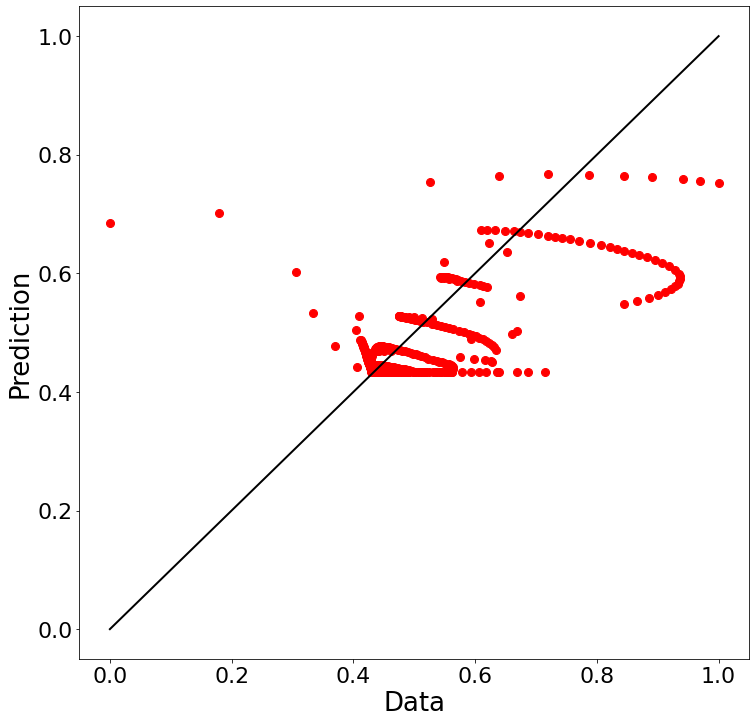

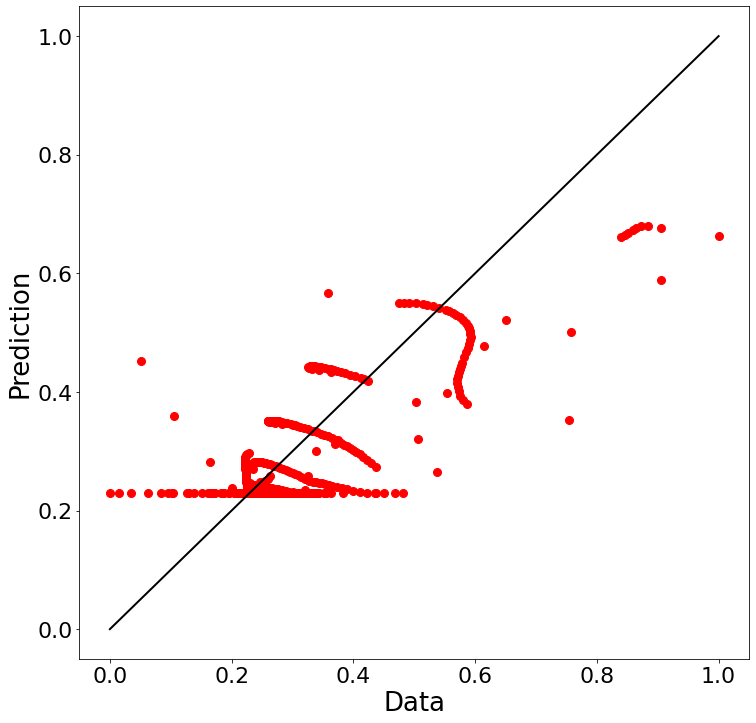

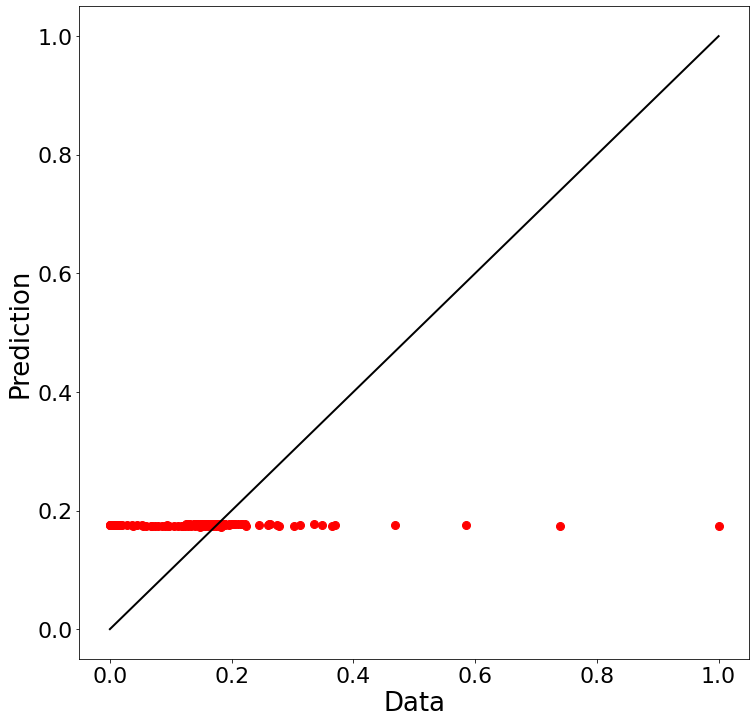

In [12]:
### Checking Predictive Accuracy

ySource_pca_ = NNModel.predict(yMatt_pca)

for iy in range(Ny):
    fig  = plt.figure(figsize=(12,12))
    xMin_ = np.amin(ySourcee_pca[:,iy])
    xMax_ = np.amax(ySourcee_pca[:,iy])
    plt.plot(ySourcee_pca[:,iy], ySource_pca_[:,iy], 'ro')
    plt.plot([xMin_,xMax_],[xMin_,xMax_],'k-')
    plt.xlabel('Data')
    plt.ylabel('Prediction')

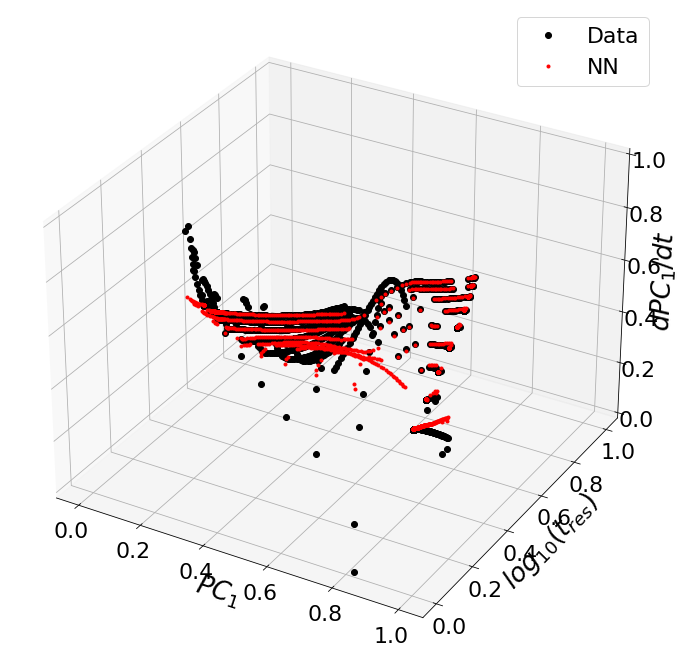

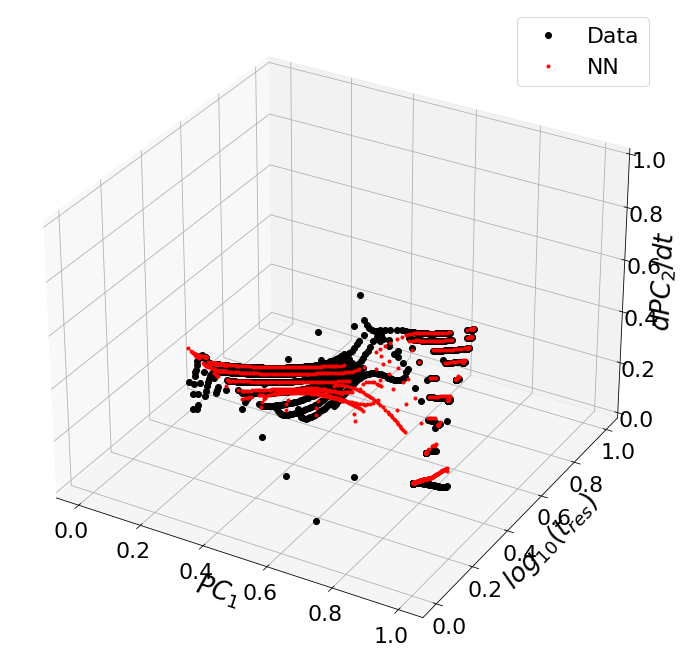

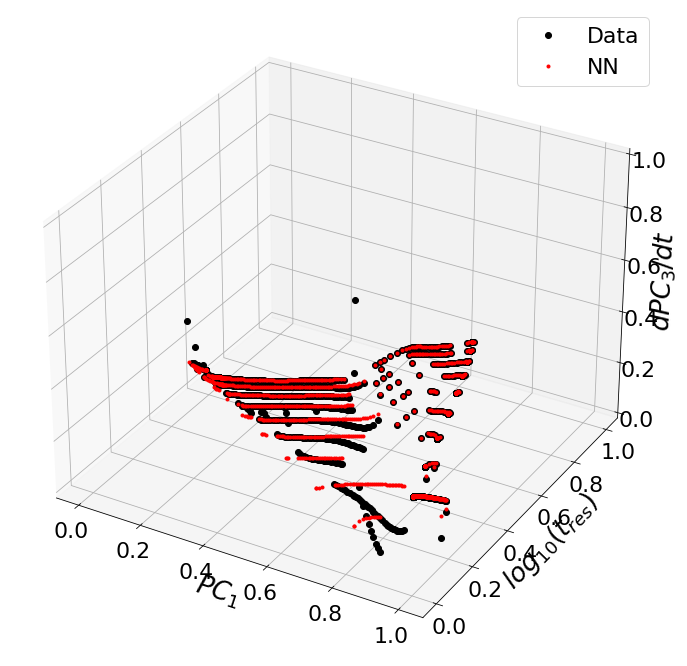

In [13]:
ySourcee_pca_ = NNModel.predict(yMatt_pca)


fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca[:,0],  'ok',  markersize=6, label='Data')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca_[:,0], 'or',  markersize=3, label='NN')
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$log_{10}(t_{res})$')
ax.set_zlabel(r'$dPC_1/dt$')
ax.legend()

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca[:,1],  'ok',  markersize=6, label='Data')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca_[:,1], 'or',  markersize=3, label='NN')
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$log_{10}(t_{res})$')
ax.set_zlabel(r'$dPC_2/dt$')
ax.legend()

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca[:,2],  'ok',  markersize=6, label='Data')
ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca_[:,2], 'or',  markersize=3, label='NN')
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$log_{10}(t_{res})$')
ax.set_zlabel(r'$dPC_3/dt$')
ax.legend()


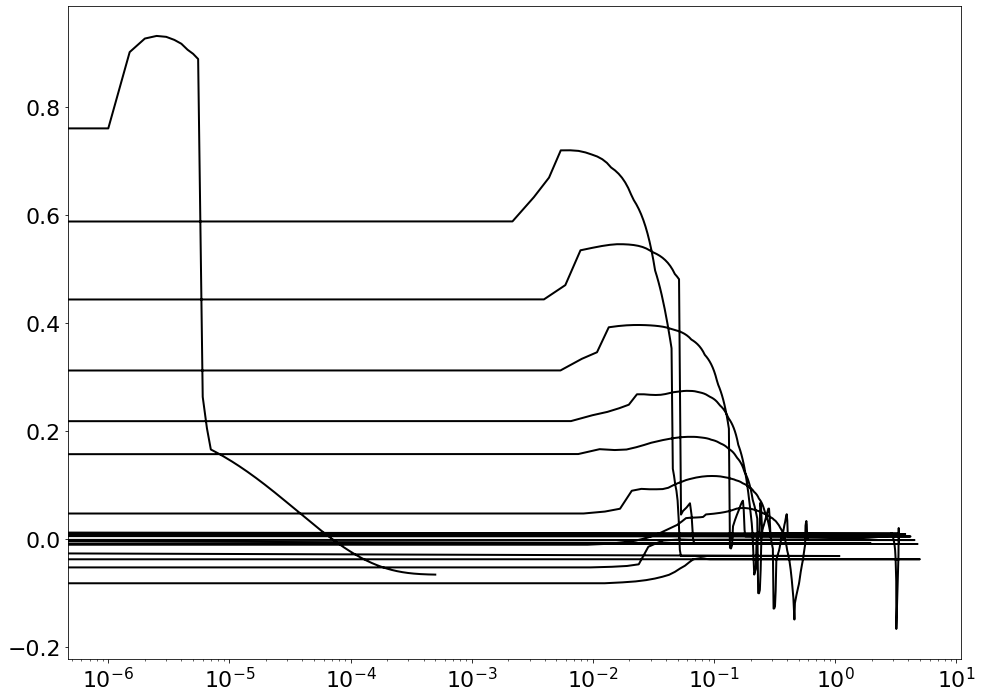

In [14]:
fig  = plt.figure(figsize=(16,12))
plt.plot( tVec, yMat_pca[:,2], '-k',  linewidth=2)
plt.xscale('log')

In [15]:
# NNModel = []

# for iy in range(1,2):


#     ### Creating Surrogate

#     LengthScale               = 5.e-2
#     Tau                       = 1.
#     RegCoeff                  = LengthScale**2 * (1.) / (2. * Nd * Tau)

#     NNModel.append(tf.keras.models.Sequential())

#     NNModel[-1].add(Dense(NNeurons[0], input_shape=(Nx,), activation=Activations[0], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
#     for iHL in range(1, len(NNeurons)):
#         NNModel[-1].add(Dense(NNeurons[iHL], activation=Activations[iHL], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
#     NNModel[-1].add(Dense(Ny, activation='linear'))
#     NNModel[-1].summary()



#     ### Training Surrogate

#     Optimizer = OptimizerName(learning_rate=LearningRate)
#     NNModel[-1].compile(optimizer=Optimizer, loss='mse')
#     Training  = NNModel[-1].fit(XTrain, yTrain[:,iy], batch_size=NBatch, epochs=1000, validation_data=(XTest, yTest[:,iy]), verbose=1);

#     LossTrainHystory = Training.history['loss']
#     LossValidHystory = Training.history['val_loss']



#     # Plotting Training and Validation Loss

#     fig = plt.figure(figsize=(12, 8))
#     plt.plot(LossTrainHystory, 'r', label='Training')
#     plt.plot(LossValidHystory, 'g', label='Validation')
#     plt.xlabel('Epoch')
#     plt.ylabel('MSE')
#     plt.yscale('log')
#     plt.legend()
# #     FigPath = FigDir+'/TrainingNN_'+str(NEpoch)+'Epoches_PCSources.png'
# #     fig.savefig(FigPath, dpi=900)
    
    
    
#     ### Checking Predictive Accuracy

#     ySource_pca_ = NNModel[-1].predict(yMatt_pca)

#     fig  = plt.figure(figsize=(12,12))
#     xMin_ = np.amin(ySourcee_pca[:,iy])
#     xMax_ = np.amax(ySourcee_pca[:,iy])
#     plt.plot(ySourcee_pca[:,iy], ySource_pca_[:,iy], 'ro')
#     plt.plot([xMin_,xMax_],[xMin_,xMax_],'k-')
#     plt.xlabel('Data')
#     plt.ylabel('Prediction')

In [16]:
# ySource_pca_ = NNModel[-1].predict(yMatt_pca)

# fig  = plt.figure(figsize=(12,12))
# xMin_ = np.amin(ySourcee_pca[:,iy])
# xMax_ = np.amax(ySourcee_pca[:,iy])
# plt.plot(ySourcee_pca[:,iy], ySource_pca_[:,iy], 'ro')
# plt.plot([xMin_,xMax_],[xMin_,xMax_],'k-')
# plt.xlabel('Data')
# plt.ylabel('Prediction')

In [17]:
### Defining Surrogate ODE

def fOrig_NN(t, y):
    print(t)
    yy   = (y - xMin)/xRange
    dydt = NNModel.predict(yy[np.newaxis,...])
    dydt = dydt*yRange + yMin
    return dydt[0,:]

y0_pca =  [-32.34328436  -0.33691511   0.23056652]
T0Val =  [3.17609126]


<Figure size 1152x864 with 0 Axes>

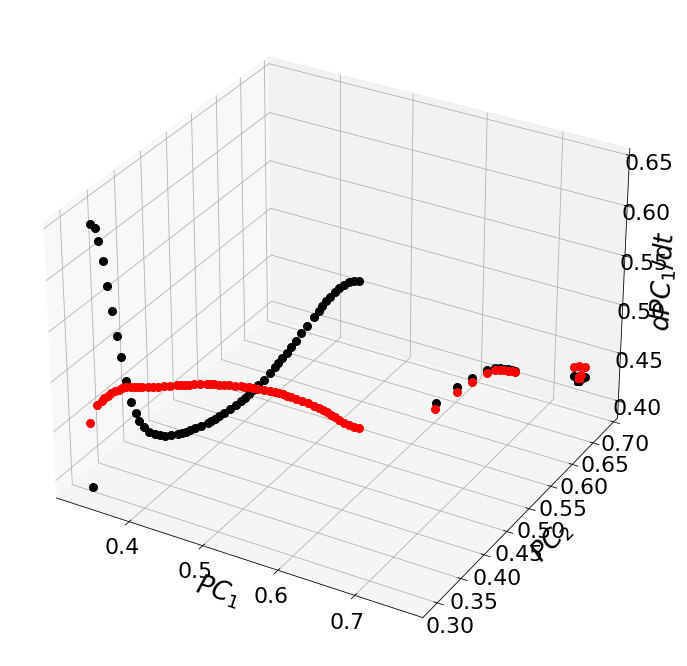

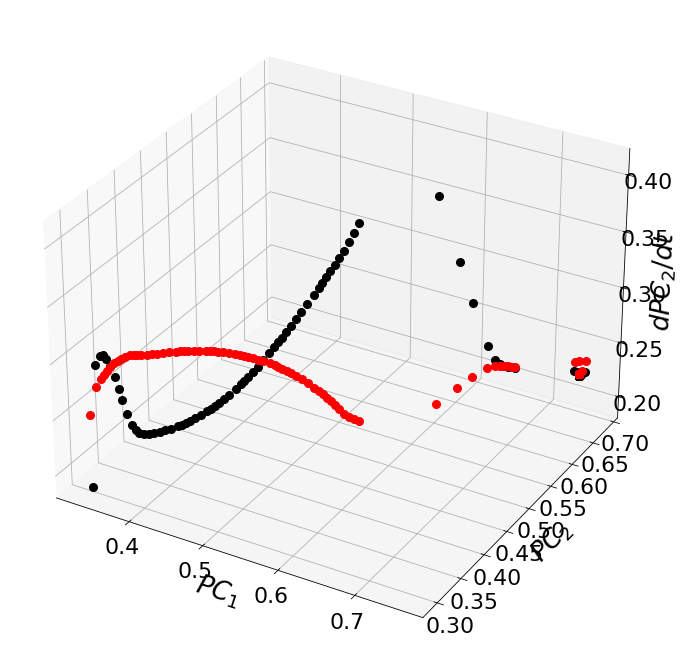

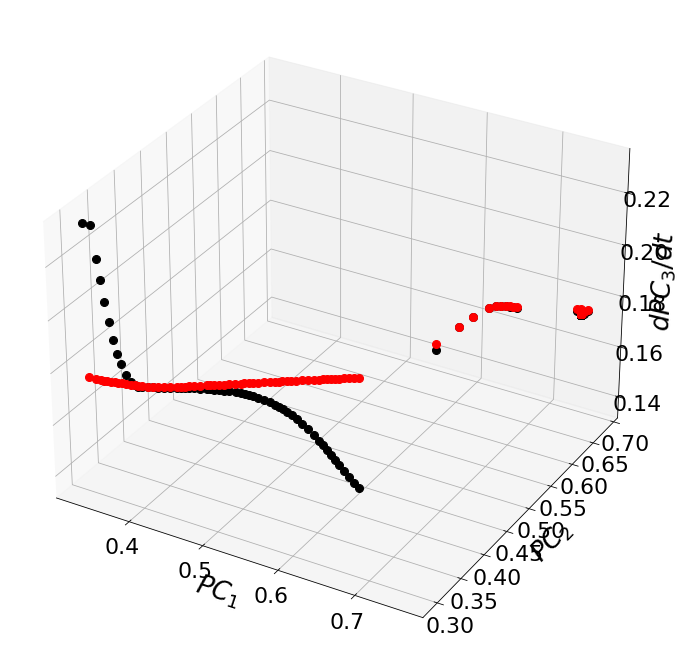

In [18]:
### Evaluating on Test Data

FileName       = TestDir + '/orig_data/T0s.csv'
Data           = pd.read_csv(FileName, header=None)
T0ValVecTest   = np.log10(Data.to_numpy())

iPC = 0

fig = plt.figure(figsize=(16,12))
for iTest in range(1):

    FileName     = TestDir+'/pc_data_'+str(NVarsRed)+'/PC.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMat_pca     = Data[Vars].to_numpy()
    y0_pca       = yMat_pca[0,:]
    print('y0_pca = ', y0_pca)
    
    FileName     = TestDir+'/pc_data_'+str(NVarsRed)+'/PCSource.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    #tVec         = Data.to_numpy()[:,0]
    ySource_pca  = Data[SVars].to_numpy()
    ySourcee_pca = (ySource_pca-yMin)/yRange

    
    T0Val        = T0ValVecTest[iTest]
    print('T0Val = ', T0Val)
    
    yMatt_pca     = (yMat_pca - xMin)/xRange
    ySourcee_pca_ = NNModel.predict(yMatt_pca)
    ySource_pca_  = yRange*ySourcee_pca_ + yMin
     

        
    fig  = plt.figure(figsize=(16,12))
    ax   = plt.axes(projection='3d')
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca[:,0],  'ok',  linewidth=2)
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca_[:,0], 'or',  linewidth=2)
    ax.set_xlabel(r'$PC_1$')
    ax.set_ylabel(r'$PC_2$')
    ax.set_zlabel(r'$dPC_1/dt$')

    fig  = plt.figure(figsize=(16,12))
    ax   = plt.axes(projection='3d')
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca[:,1],  'ok',  linewidth=2)
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca_[:,1], 'or',  linewidth=2)
    ax.set_xlabel(r'$PC_1$')
    ax.set_ylabel(r'$PC_2$')
    ax.set_zlabel(r'$dPC_2/dt$')

    fig  = plt.figure(figsize=(16,12))
    ax   = plt.axes(projection='3d')
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca[:,2],  'ok',  linewidth=2)
    ax.plot3D( yMatt_pca[:,0], yMatt_pca[:,1], ySourcee_pca_[:,2], 'or',  linewidth=2)
    ax.set_xlabel(r'$PC_1$')
    ax.set_ylabel(r'$PC_2$')
    ax.set_zlabel(r'$dPC_3/dt$')

y0_pca =  [-32.34328436  -0.33691511   0.23056652]
0.0
8.814630531464151e-07
1.76292610629283e-05
2.6443891594392453e-05
7.05170442517132e-05
7.835227139079245e-05
8.814630531464151e-05
8.814630531464151e-05
0.00010735113124058053
0.00011695354420355004
0.0001649656090183976
0.00017350108720770382
0.00018417043494433662
0.00018417043494433662
9.851105669970021e-05
0.00010369343239222955
0.0001296053108548763
0.0001342118670260135
0.000139970062239935
0.000139970062239935
0.0001503348136249937
0.00015551718931752304
0.00018142906778016978
0.000186035623951307
0.00019179381916522849
0.00019179381916522849
0.0001460135855963141
0.00014903534727450364
0.00016414415566545141
0.00016683016604606435
0.00017018767902183052
0.00017018767902183052
0.00017623120237820962
0.0001792529640563992
0.00019436177244734694
0.00019704778282795987
0.00020040529580372604
0.00020040529580372604
0.00017551903714043535
0.00017818471619973777
0.00019151311149624985
0.00019388260399340755
0.00019684446961485468


0.002393714388842107
0.002393714388842107
0.002401792190048885
0.002405831090652274
0.0024260255936692197
0.002429615727538899
0.0024341033948759977
0.0024341033948759977
0.0024421811997913916
0.0024462201022490884
0.0024664146145375733
0.002470004750055526
0.002474492419452967
0.002474492419452967
0.0024825702474983486
0.0024866091615210395
0.0025068037316344936
0.0025103938774324406
0.002514881559679875
0.002514881559679875
0.0025229593810467787
0.0025269982917302306
0.0025471928451474904
0.0025507829879772253
0.002555270666514394
0.002555270666514394
0.0025633485033552186
0.0025673874217756313
0.002587582013877693
0.002591172163584726
0.0025956598507185175
0.0025956598507185175
0.0026037377088309
0.002607776637887091
0.002627971283168046
0.002631561442329105
0.0026360491412804284
0.0026360491412804284
0.0026441269826352996
0.0026481659033127354
0.0026683605066999136
0.0026719506584131896
0.002676438348054785
0.002676438348054785
0.0026845161735265773
0.0026885550862624738
0.00270874

0.002715034929914644
0.002715034929914644
0.002715034929913728
0.002715034929913747
0.0027150349299138424
0.0027150349299138593
0.0027150349299138806
0.0027150349299138806
0.0027150349299139187
0.002715034929913938
0.002715034929914033
0.00271503492991405
0.0027150349299140714
0.0027150349299140714
0.0027150349299138884
0.002715034929913892
0.002715034929913911
0.0027150349299139144
0.0027150349299139187
0.0027150349299139187
0.0027150349299138823
0.0027150349299138827
0.0027150349299138866
0.0027150349299138875
0.0027150349299138884
0.0027150349299138884
0.00271503492991389
0.0027150349299138905
0.0027150349299138944
0.0027150349299138953
0.002715034929913896
0.002715034929913896
0.0027150349299139118
0.0027150349299139196
0.0027150349299139586
0.0027150349299139656
0.0027150349299139742
0.0027150349299139742
0.002715034929913899
0.002715034929913901
0.0027150349299139087
0.00271503492991391
0.0027150349299139118
0.0027150349299139118


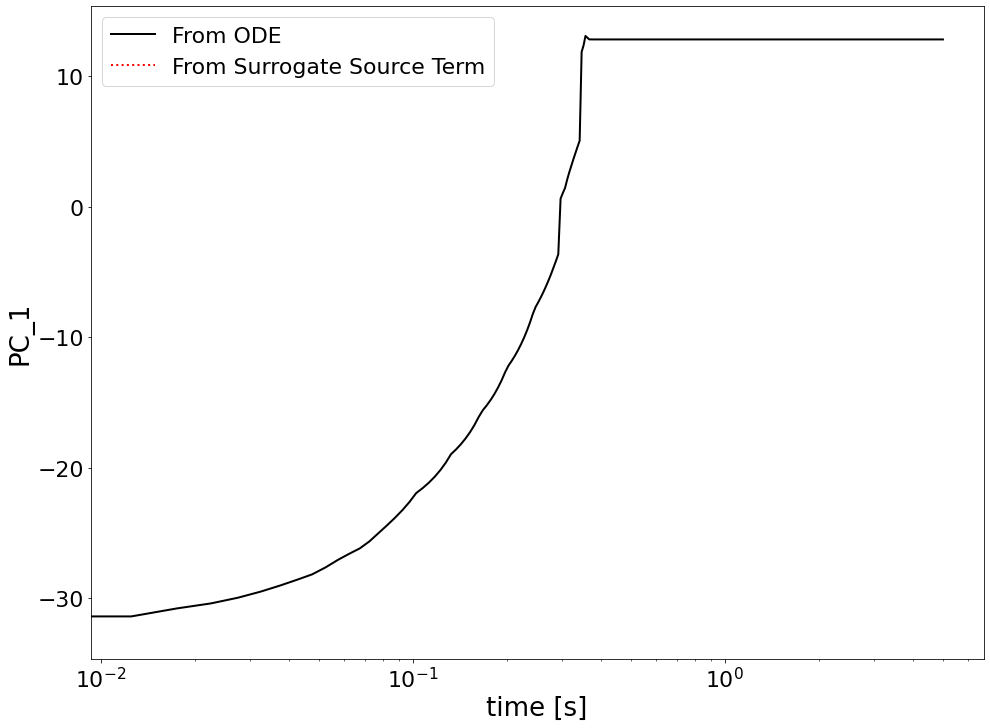

In [19]:
### Evaluating on Test Data

FileName       = TestDir + '/orig_data/T0VecTot.csv'
Data           = pd.read_csv(FileName, header=None)
T0ValVecTest   = np.log10(Data.to_numpy())

iPC = 0

fig = plt.figure(figsize=(16,12))
for iTest in range(1):

    FileName     = TestDir+'/pc_data_'+str(NVarsRed)+'/PC.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMat_pca     = Data[Vars].to_numpy()
    y0_pca       = yMat_pca[0,:]
    print('y0_pca = ', y0_pca)
    
    T0Val        = T0ValVecTest[iTest]
    
    plt.plot(tVec, yMat_pca[:,iPC], '-k', label='From ODE', lw=2)
    
    output       = solve_ivp( fOrig_NN, tVec[[0,-1]], y0_pca, method='RK45', t_eval=tVec, atol=1.e-8 )
    tNN          = output.t
    yMat_pca_    = output.y.T
    
    plt.plot(tNN, yMat_pca_[:,iPC], ':r', label='From Surrogate Source Term', lw=2)

plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel('PC_'+str(iPC+1))
plt.legend()

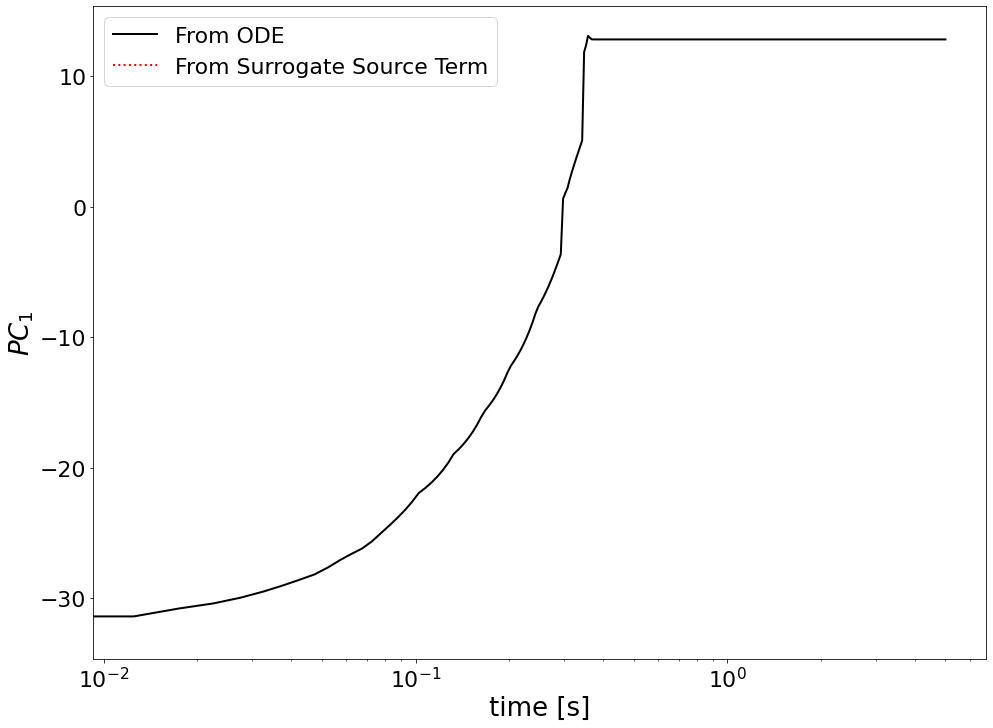

In [20]:
iPC = 0

fig = plt.figure(figsize=(16,12))
plt.plot(tVec, yMat_pca[:,iPC], '-k', label='From ODE',                   lw=2)
plt.plot(tNN, yMat_pca_[:,iPC], ':r', label='From Surrogate Source Term', lw=2)
plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel('$PC_'+str(iPC+1)+'$')
plt.legend()
#plt.ylim([-2000.0, 2500.])

In [21]:
FileName = OutputDir+'/pca_'+str(NVarsRed)+'/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/pca_'+str(NVarsRed)+'/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/pca_'+str(NVarsRed)+'/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

In [22]:
yMat_    = (yMat_pca_.dot(A))*D[:,0] + C[:,0]

iVar =  16


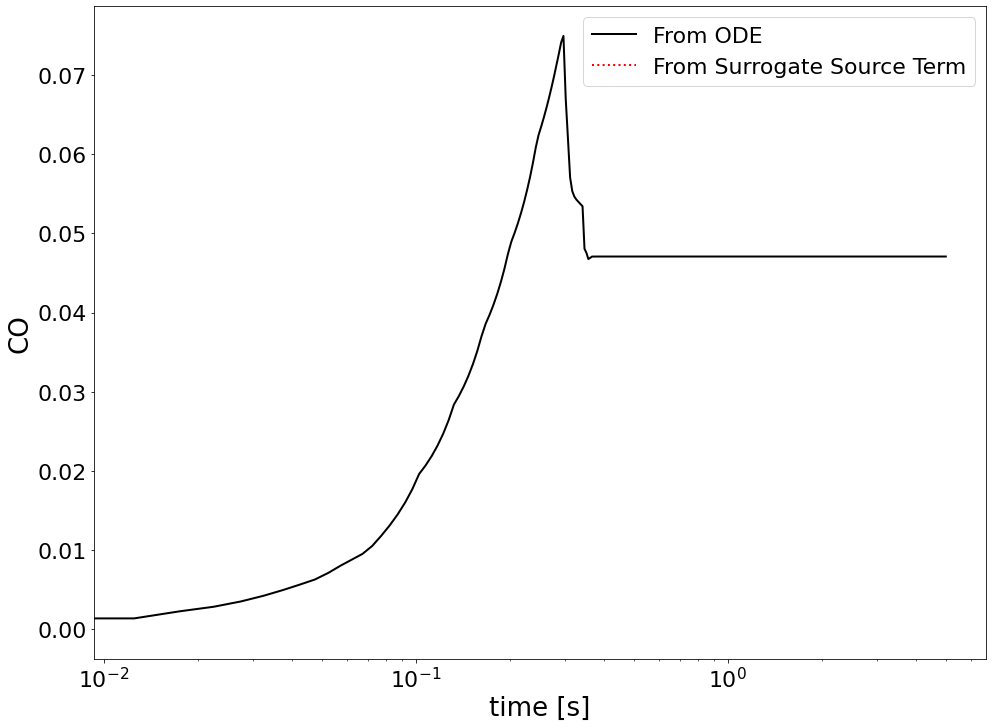

In [23]:
VarOI = 'CO'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break
        
fig = plt.figure(figsize=(16,12))
for iTest in range(1):

    FileName     = TestDir+'/orig_data/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMat         = Data.to_numpy()[:,1:]
        
    plt.plot(tVec, yMat[:,iVar-1], '-k', label='From ODE',                   lw=2)
    plt.plot(tNN, yMat_[:,iVar-1], ':r', label='From Surrogate Source Term', lw=2)

plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel(VarOI)
plt.legend()

In [24]:
ModelFile = OutputDir + '/NN_Sources/'

NNModel.save(ModelFile)

INFO:tensorflow:Assets written to: /Users/sventur/WORKSPACE//ROMNet/Data_10_0DReact//NN_Sources/assets


In [25]:
### Write Data

FileName       = OutputDir + '/orig_data/ResidenceTimes.csv'
Data           = pd.read_csv(FileName, header=None)
T0ValVec       = np.log10(Data.to_numpy())

for iTrain in range(10):

    FileName     = OutputDir+'/pc_data_'+str(NVarsRed)+'/PC.csv.'+str(iTrain+1)
    Data         = pd.read_csv(FileName, header=0)
    yMat_pca     = Data[Vars].to_numpy()
    
    T0Val        = T0ValVec[iTrain]
    T0Vec        = np.ones((yMat_pca.shape[0],1)) * T0Val
    
    FileName     = '/Users/sventuri/Desktop/Data/PC_Augmented.csv.'+str(iTrain+1)
    Header       = 'PC1,PC2,PC3'
    np.savetxt(FileName, yMat_pca, delimiter=',', header=Header, comments='')
    
    
    
    
    FileName     = OutputDir+'/pc_data_'+str(NVarsRed)+'/PCSource.csv.'+str(iTrain+1)
    Data         = pd.read_csv(FileName, header=0)
    ySources_pca = Data[SVars].to_numpy()
    
    FileName     = '/Users/sventuri/Desktop/Data/PCSource.csv.'+str(iTrain+1)
    Header       = 'SPC1,SPC2,SPC3'
    np.savetxt(FileName, ySources_pca, delimiter=',', header=Header, comments='')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sventur/WORKSPACE//ROMNet/Data_10_0DReact//orig_data/ResidenceTimes.csv'